In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

# Modèle Linéaire

In [8]:
class resLin(nn.Module) :
    def __init__(self, nin, nout) :
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.Layer1 = nn.Linear(nin,nout)
        
    def forward(self, tX) :
        x = self.Layer1(tX)
        return x
    
    def zero_grad(self, set_to_none: bool = False) -> None:
        return super().zero_grad(set_to_none)
    
    def set_params(self, param_list):
        for p1, p2 in zip(list(self.parameters()), param_list) :
            p1.data = p2
        return self

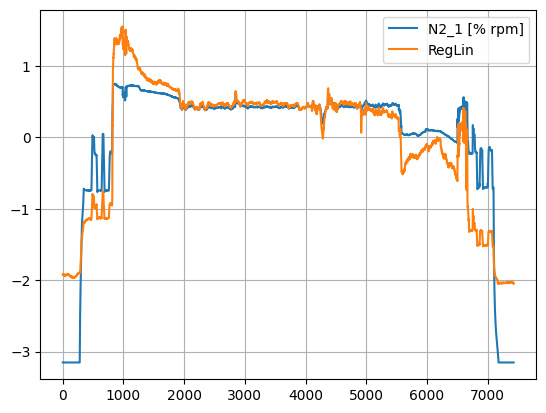

In [9]:
variableNames = ["N1_1 [% rpm]", "T1_1 [deg C]", "ALT [ft]", "M [Mach]"]
# X = ddf.partitions[0][variableNames].compute().values
f = open("../data_prepare/variables.npy", "rb")
X = np.load(f)
f.close()
Xnorm = (X - X.mean(axis=0)) / X.std(axis=0)
Xhat = np.concatenate((np.ones(X.shape[0]).reshape(-1, 1), Xnorm), axis=1)

targetName = ["N2_1 [% rpm]"]
# y = ddf.partitions[0][targetName].compute().values.reshape(-1, 1)
f = open("../data_prepare/target.npy", "rb")
y = np.load(f)
f.close()

yNorm = (y - y.mean(axis=0)) / y.std(axis=0)

aHat = np.linalg.solve(np.matmul(Xhat.transpose(), Xhat),
                       np.matmul(Xhat.transpose(), yNorm))
yHat = np.matmul(Xhat, aHat)


plt.figure()
plt.plot(yNorm, label=targetName[0])
plt.plot(yHat, label="RegLin")
plt.legend()
plt.grid("on")
plt.show()


In [10]:
tX = torch.Tensor(Xnorm)
ty = torch.Tensor(yNorm)
tyHat = torch.Tensor(yHat)

print("tX.shape : ", tX.shape)
print("ty.shape : ", ty.shape)
print("tyHat.shape :", tyHat.shape)

tX.shape :  torch.Size([7429, 4])
ty.shape :  torch.Size([7429, 1])
tyHat.shape : torch.Size([7429, 1])


In [11]:
# Hypperparamètres
N = 2000
ns = [4,1]
nbParams = 2 * (len(ns) - 1)

In [12]:
myModel = resLin(1, 1)

In [13]:
thetas = []
for idxList in range(N) : 
    idxParam = 0

    param = []
    for idxParam in range(nbParams) :
        f = open("../data_prepare/rotParams/{}_{}_lin.pt".format(idxList, idxParam), "rb")
        param.append(torch.load(f))
        f.close()
    
    thetas.append(param)

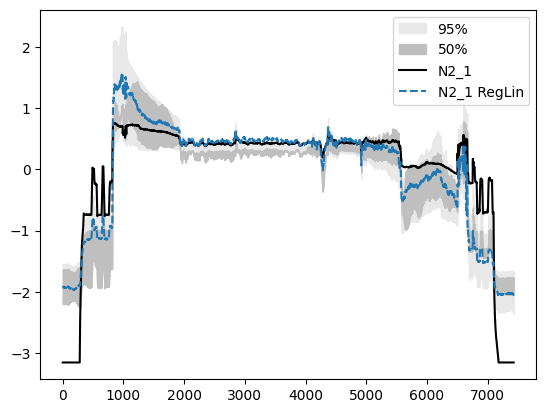

In [15]:
y_hats = torch.concatenate(
            tuple([myModel.set_params(theta).forward(tX) for theta in thetas]), 1)
q2_5 = y_hats.quantile(0.025, 1).reshape(-1,1).detach().numpy()
q97_5 = y_hats.quantile(0.975, 1).reshape(-1,1).detach().numpy()
q25 = y_hats.quantile(0.25, 1).reshape(-1,1).detach().numpy()
q75 = y_hats.quantile(0.75, 1).reshape(-1,1).detach().numpy()
med = y_hats.quantile(0.5, 1).reshape(-1,1).detach().numpy()
plt.clf()


plt.fill_between(np.arange(ty.shape[0]), q2_5[:, 0],
                 q97_5[:, 0], color="#e8e8e8", label='95%')

plt.fill_between(np.arange(ty.shape[0]), q25[:, 0], q75[:, 0],
                 color="#bfbfbf", label='50%')

# plt.plot(med, label="mediane", color="#8c0e11")

plt.plot(ty, label='N2_1', color = 'k')

plt.plot(tyHat, label="N2_1 RegLin", linestyle='dashed')

plt.legend()
plt.show()


In [16]:
thetaRavel = torch.concatenate(tuple([torch.concatenate(tuple([p.ravel() for p in theta])).reshape(-1,1) for theta in thetas]), 1)

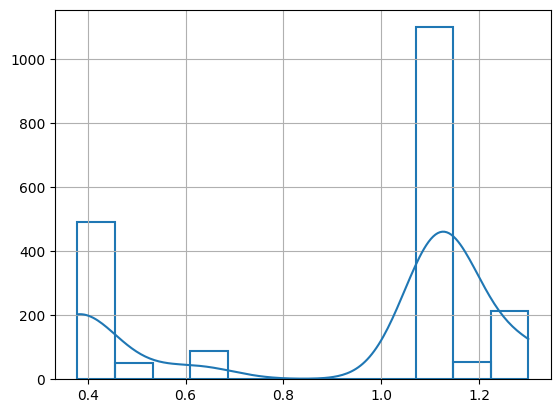

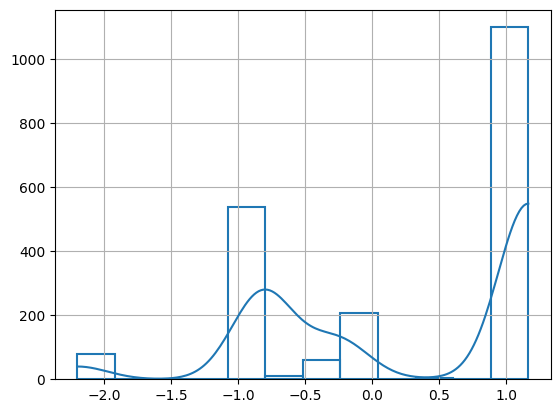

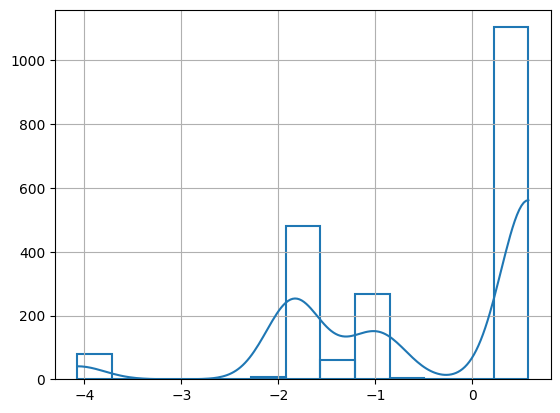

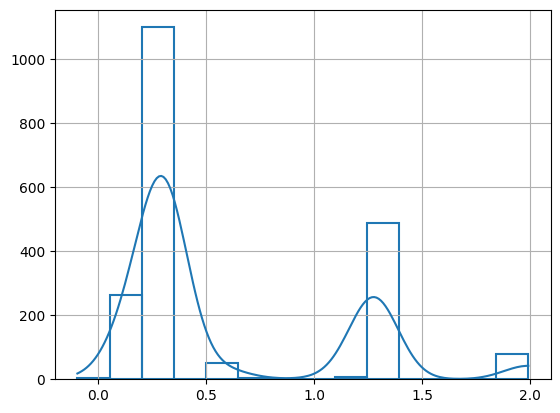

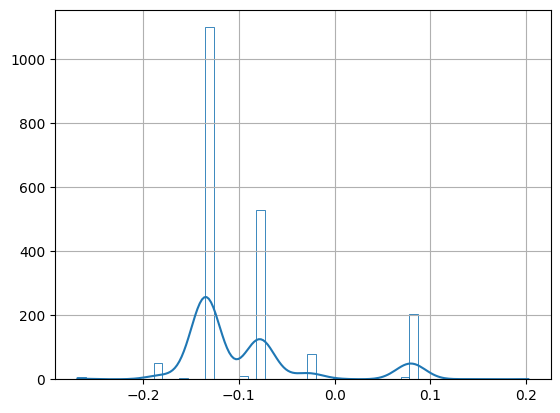

In [17]:
for k in range(thetaRavel.shape[0]) :
    plt.figure()
    sns.histplot(thetaRavel[k,:].detach().numpy(), kde = True, fill = False)
    plt.grid('on')
    plt.ylabel(None)

<Figure size 640x480 with 0 Axes>

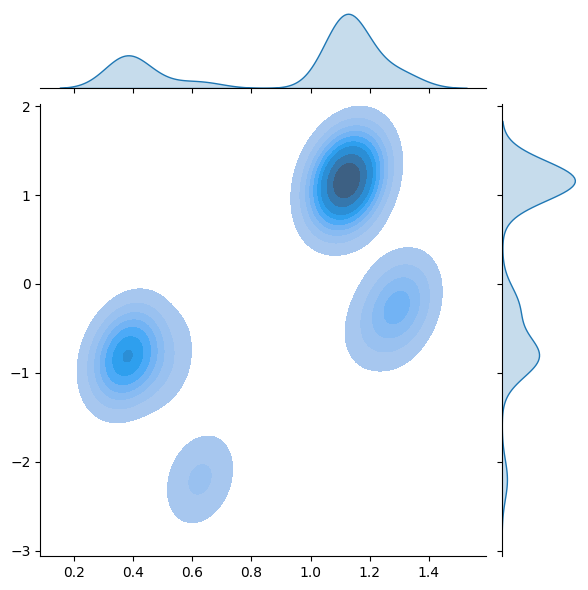

In [20]:
plt.figure()
s = 0
d = 1
sns.jointplot(x = thetaRavel[s,:].detach().numpy(), y = thetaRavel[d,:].detach().numpy(), kind='kde', fill=True)
plt.show()

# Modèle Réseau de neurones 4-2-1

In [22]:
class resNet(nn.Module) :
    def __init__(self, nin, nout) :
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.Layer1 = nn.Linear(nin,2)
        self.Layer2 = nn.Linear(2, nout)

    def forward(self, tX) :
        x = self.Layer1(tX)
        x = torch.relu(x)
        x = self.Layer2(x)
        return x
    
    def zero_grad(self, set_to_none: bool = False) -> None:
        return super().zero_grad(set_to_none)
    
    def set_params(self, param_list):
        for p1, p2 in zip(list(self.parameters()), param_list) :
            p1.data = p2
        return self

In [21]:
# Hypperparamètres
N = 5000
ns = [4,2,1]
nbParams = 2 * (len(ns) - 1)

In [25]:
thetas = []
for idxList in range(N) : 
    idxParam = 0

    param = []
    for idxParam in range(nbParams) :
        f = open("../data_prepare/rotParams/{}_{}_net.pt".format(idxList, idxParam), "rb")
        param.append(torch.load(f))
        f.close()
    
    thetas.append(param)

In [27]:
myModel = resNet(1,1)

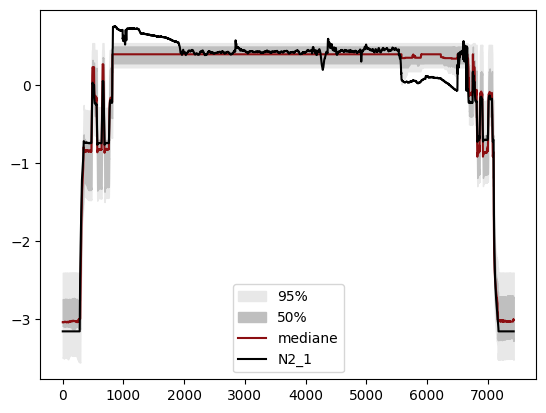

In [28]:
y_hats = torch.concatenate(
            tuple([myModel.set_params(theta).forward(tX) for theta in thetas]), 1)
q2_5 = y_hats.quantile(0.025, 1).reshape(-1,1).detach().numpy()
q97_5 = y_hats.quantile(0.975, 1).reshape(-1,1).detach().numpy()
q25 = y_hats.quantile(0.25, 1).reshape(-1,1).detach().numpy()
q75 = y_hats.quantile(0.75, 1).reshape(-1,1).detach().numpy()
med = y_hats.quantile(0.5, 1).reshape(-1,1).detach().numpy()
plt.clf()
plt.fill_between(np.arange(ty.shape[0]), q2_5[:, 0],
                 q97_5[:, 0], color="#e8e8e8", label='95%')

plt.fill_between(np.arange(ty.shape[0]), q25[:, 0], q75[:, 0],
                 color="#bfbfbf", label='50%')

plt.plot(med, label="mediane", color="#8c0e11")

plt.plot(ty, label='N2_1', color = 'k')

# plt.plot(tyHat, label="N2_1 RegLin", linestyle='dashed')

plt.legend()
plt.show()

In [29]:
thetaRavel = torch.concatenate(tuple([torch.concatenate(tuple([p.ravel() for p in theta])).reshape(-1,1) for theta in thetas]), 1)

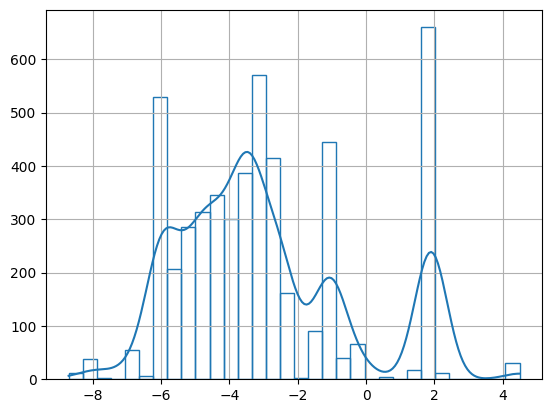

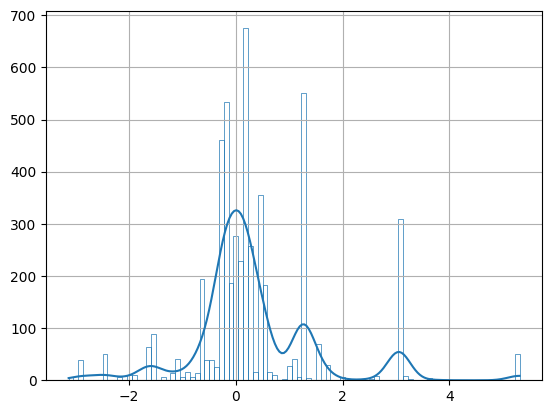

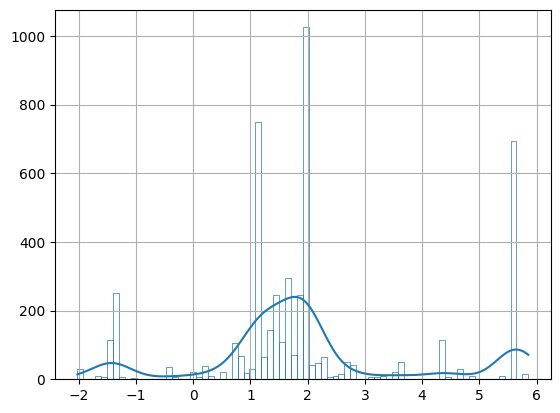

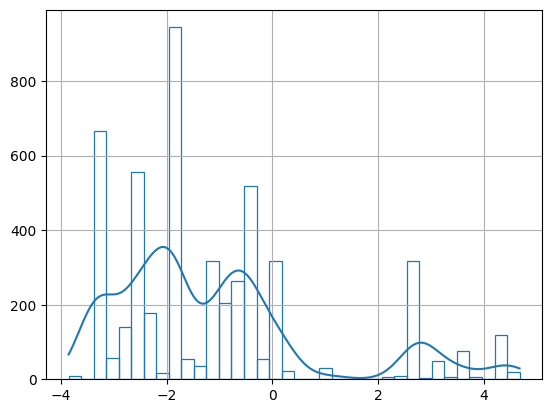

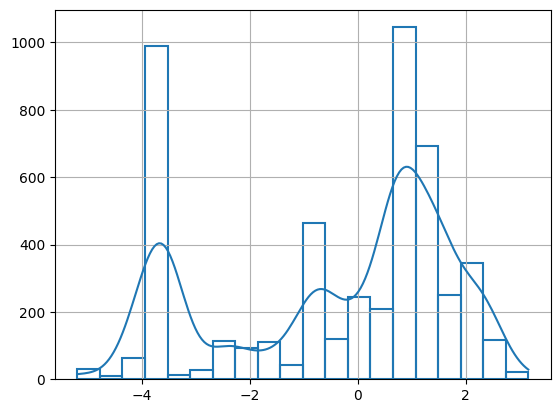

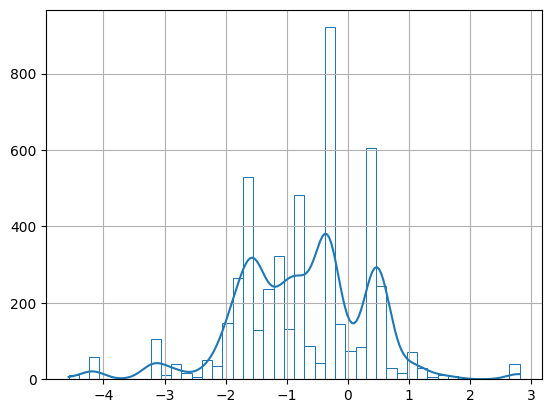

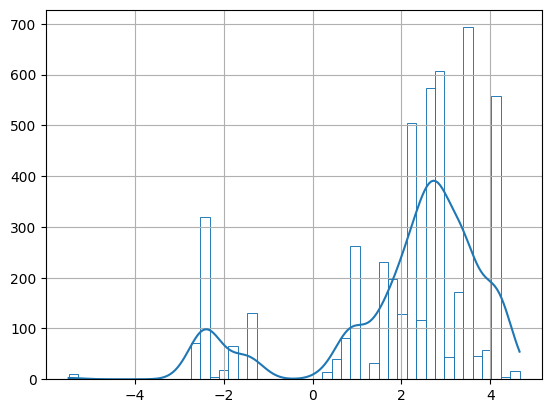

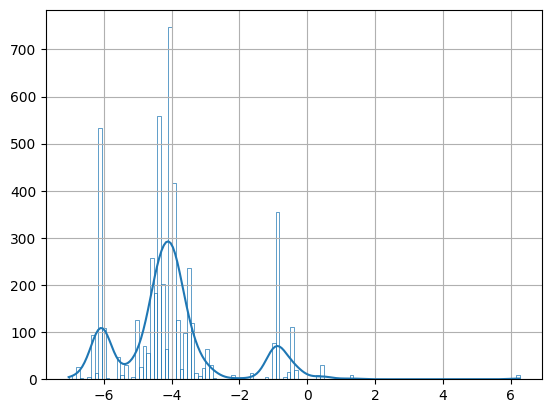

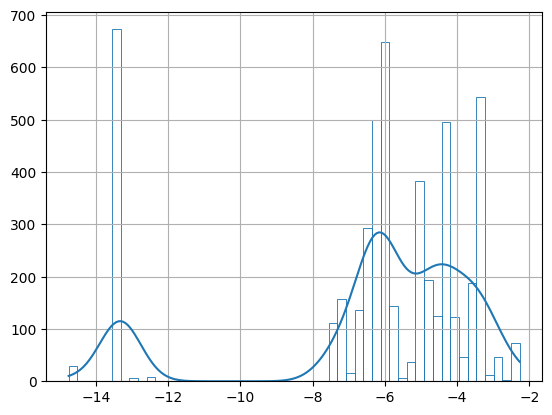

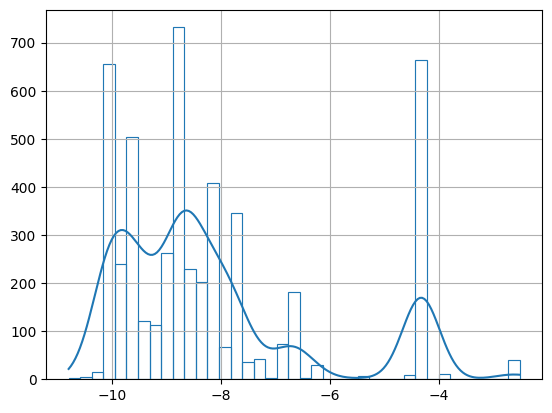

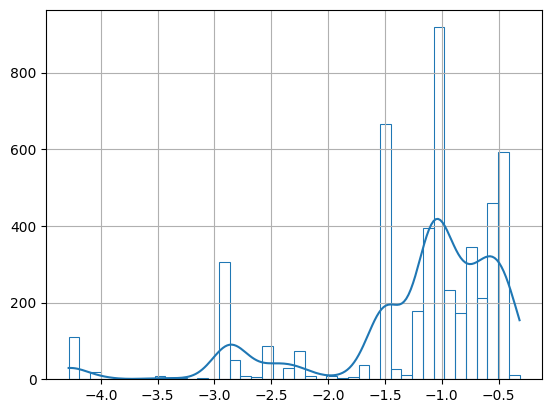

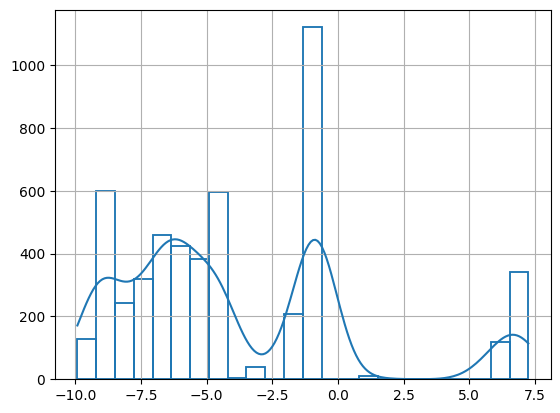

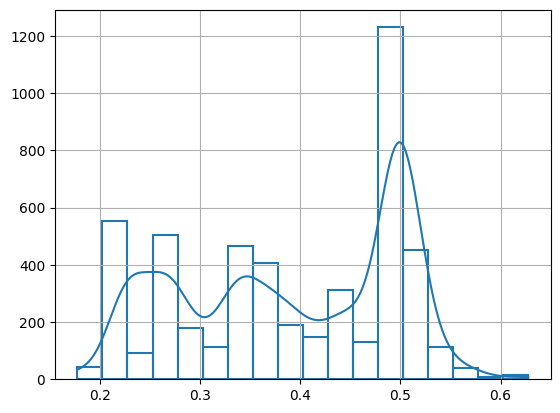

In [30]:
for k in range(thetaRavel.shape[0]) :
    plt.figure()
    sns.histplot(thetaRavel[k,:].detach().numpy(), kde = True, fill = False)
    plt.grid('on')
    plt.ylabel(None)

<Figure size 640x480 with 0 Axes>

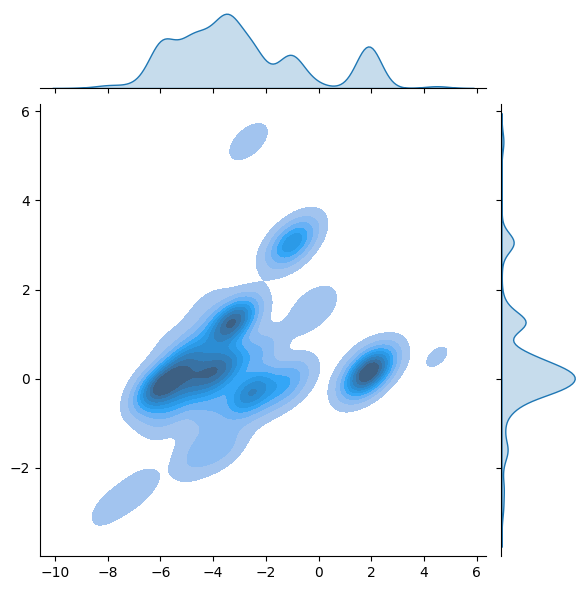

In [31]:
plt.figure()
s = 0
d = 1
sns.jointplot(x = thetaRavel[s,:].detach().numpy(), y = thetaRavel[d,:].detach().numpy(), kind='kde', fill=True)
plt.show()